

#Exploratory Data Analysis & Machine Learning on Netflix Movies & TV Shows

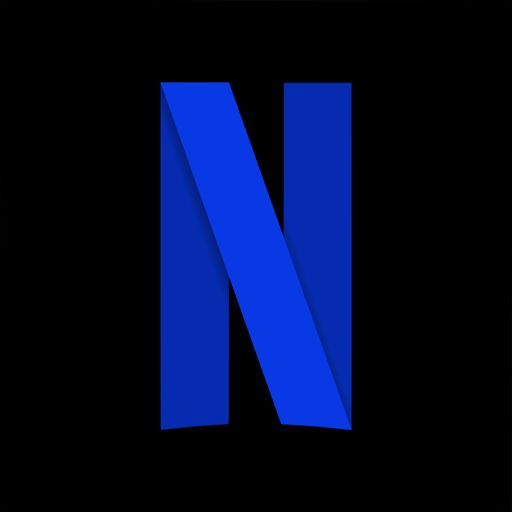

#Install and imports the necessary libraries

In [ ]:
!pip install -q wordcloud nltk
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 1. Load dataset
FILE_PATH = "/content/netflix_titles.csv"  # In Colab you may need to upload and set path
if not os.path.exists(FILE_PATH):
    # Try common alternative if running in Colab (user can upload to /content)
    alt = "/content/netflix_titles.csv"
    if os.path.exists(alt):
        FILE_PATH = alt
    else:
        raise FileNotFoundError(f"Dataset not found at {FILE_PATH}. Upload netflix_titles.csv to /content or update FILE_PATH.")

In [ ]:
df = pd.read_csv("/content/netflix_titles.csv")
print("Dataset loaded. Shape:", df.shape)
display(df.head())

Dataset loaded. Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


#Basic cleaning & helper columns

In [ ]:
df_clean = df.copy()

# Standardize column names (lowercase)

In [ ]:
df_clean.columns = [c.strip() for c in df_clean.columns]

# Parse date_added

In [ ]:
def try_parse_date(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

if 'date_added' in df_clean.columns:
    df_clean['date_added_parsed'] = df_clean['date_added'].apply(try_parse_date)
    df_clean['added_year'] = df_clean['date_added_parsed'].dt.year
    df_clean['added_month'] = df_clean['date_added_parsed'].dt.month

# Split duration to numeric mins / seasons

In [ ]:
def parse_duration(x):
    if pd.isna(x): return None
    x = str(x).strip()
    if 'Season' in x or 'Seasons' in x:
        # extract number
        m = re.search(r'(\d+)', x)
        if m:
            return int(m.group(1))
        return np.nan
    else:
        # minutes e.g. "90 min"
        m = re.search(r'(\d+)', x)
        if m:
            return int(m.group(1))
        return np.nan

In [ ]:
df_clean['duration_num'] = df_clean['duration'].apply(parse_duration)
df_clean['is_tv'] = df_clean['type'].str.lower().eq('tv show') | df_clean['type'].str.lower().eq('tv show'.lower())

# Normalize listed_in (genres) -> keep as raw string and also as list

In [ ]:
def split_genres(x):
    if pd.isna(x): return []
    return [g.strip() for g in str(x).split(',') if g.strip()]
df_clean['genres_list'] = df_clean['listed_in'].apply(split_genres)

# Normalize country into list

In [ ]:
def split_country(x):
    if pd.isna(x): return []
    return [c.strip() for c in str(x).split(',') if c.strip()]

df_clean['country_list'] = df_clean['country'].apply(split_country)

# Directors and cast into lists

In [ ]:
df_clean['director_list'] = df_clean['director'].fillna('').apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
df_clean['cast_list'] = df_clean['cast'].fillna('').apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])

#Summary counts

In [ ]:
total_titles = len(df_clean)
num_movies = (df_clean['type'].str.lower() == 'movie').sum()
num_tv = (df_clean['type'].str.lower() == 'tv show').sum()
print(f"Total titles: {total_titles} | Movies: {num_movies} | TV shows: {num_tv}")

Total titles: 8807 | Movies: 6131 | TV shows: 2676


#Top genres (overall, movies, tv)

In [ ]:
def top_genres(df, topn=20):
    cnt = Counter()
    for gl in df['genres_list']:
        cnt.update(gl)
    return pd.DataFrame(cnt.most_common(topn), columns=['genre','count'])


In [ ]:
top_genres_overall = top_genres(df_clean, 30)
top_genres_overall.to_csv("top_genres_overall.csv", index=False)
print("Top genres (overall):")
display(top_genres_overall.head(15))

Top genres (overall):


,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


# Plot top genres

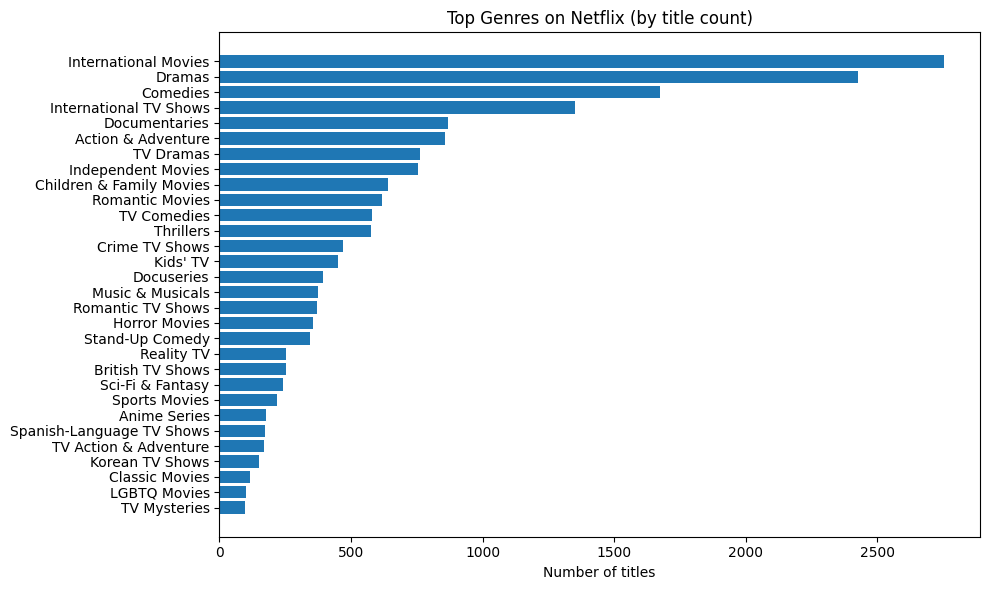

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(top_genres_overall['genre'].iloc[::-1], top_genres_overall['count'].iloc[::-1])
plt.title("Top Genres on Netflix (by title count)")
plt.xlabel("Number of titles")
plt.tight_layout()
plt.savefig("top_genres_overall.png")
plt.show()

#Top countries

In [ ]:
def top_countries(df, topn=20):
    cnt = Counter()
    for cl in df['country_list']:
        cnt.update(cl)
    return pd.DataFrame(cnt.most_common(topn), columns=['country','count'])

In [ ]:
top_countries_df = top_countries(df_clean, 30)
top_countries_df.to_csv("top_countries.csv", index=False)
print("Top countries producing titles:")
display(top_countries_df.head(15))

Top countries producing titles:


,country,count
0,United States,3690
1,India,1046
2,United Kingdom,806
3,Canada,445
4,France,393
5,Japan,318
6,Spain,232
7,South Korea,231
8,Germany,226
9,Mexico,169


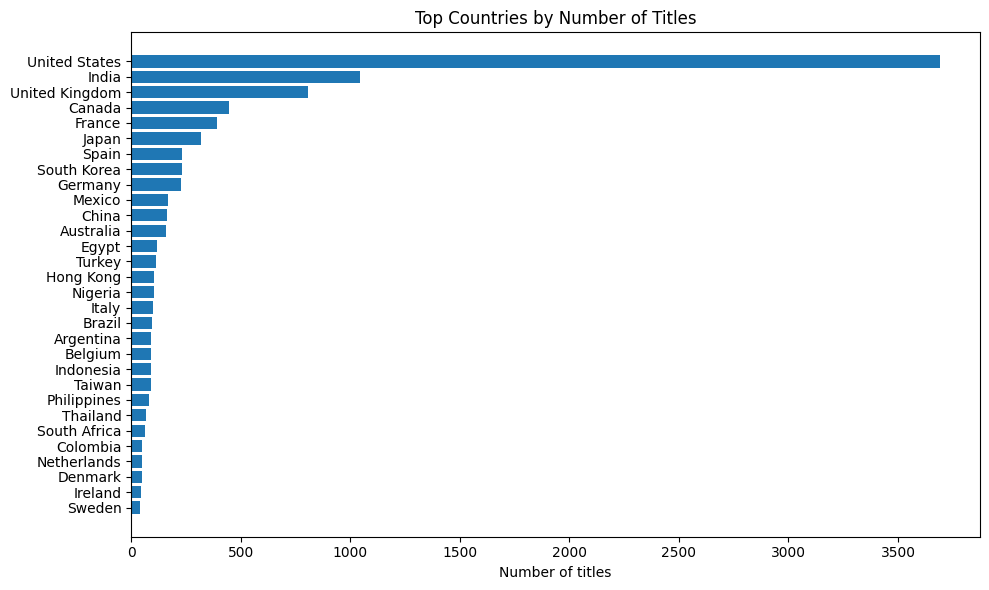

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(top_countries_df['country'].iloc[::-1], top_countries_df['count'].iloc[::-1])
plt.title("Top Countries by Number of Titles")
plt.xlabel("Number of titles")
plt.tight_layout()
plt.savefig("top_countries.png")
plt.show()

#Release year and added-year trends

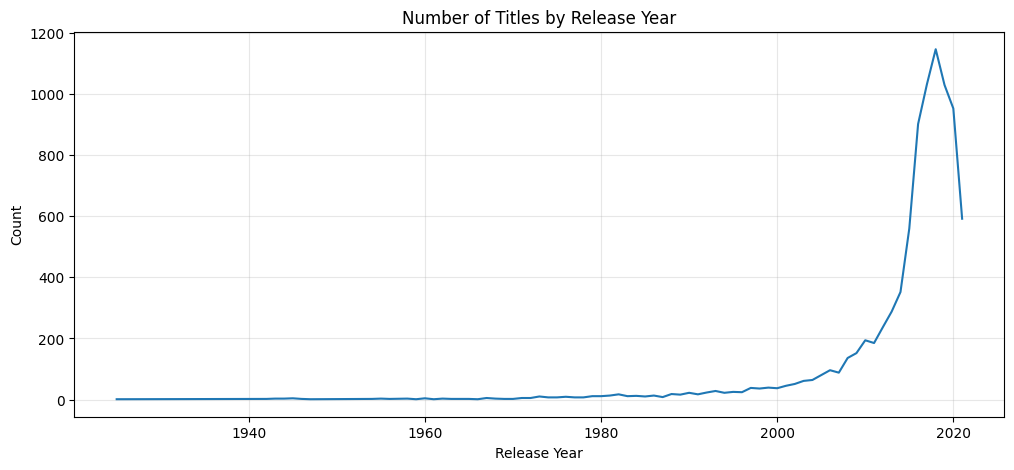

In [ ]:
# Releases per release_year
releases_by_year = df_clean['release_year'].value_counts().sort_index()
plt.figure(figsize=(12,5))
plt.plot(releases_by_year.index, releases_by_year.values)
plt.title("Number of Titles by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.savefig("releases_by_release_year.png")
plt.show()

# Titles added to Netflix by year (date_added_parsed)

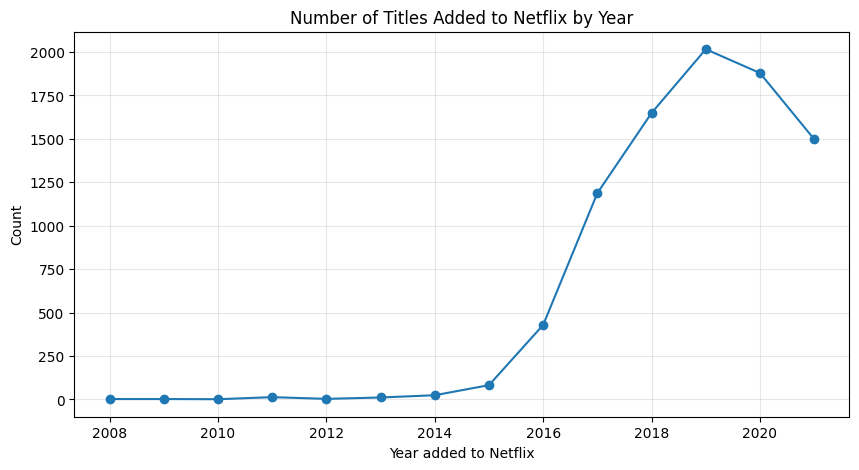

In [ ]:
if 'added_year' in df_clean.columns:
    added_by_year = df_clean['added_year'].value_counts().sort_index()
    plt.figure(figsize=(10,5))
    plt.plot(added_by_year.index, added_by_year.values, marker='o')
    plt.title("Number of Titles Added to Netflix by Year")
    plt.xlabel("Year added to Netflix")
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.savefig("added_by_year.png")
    plt.show()
    added_by_year.to_csv("added_by_year.csv")

#Ratings distribution

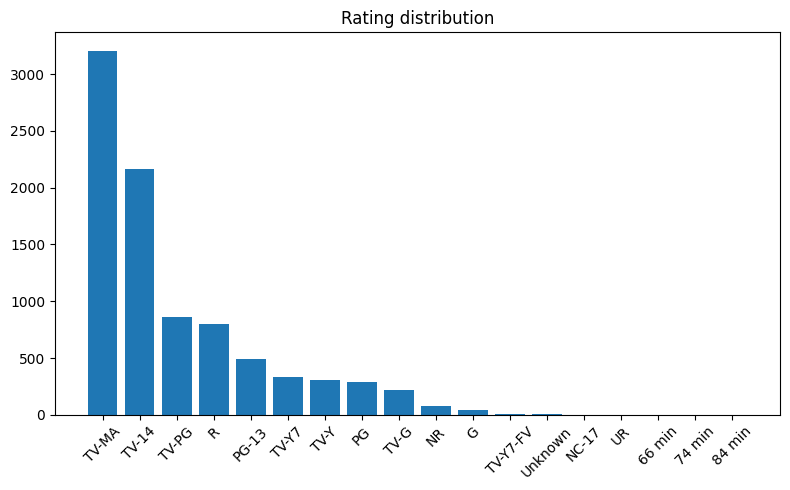

In [ ]:
if 'rating' in df_clean.columns:
    rating_counts = df_clean['rating'].fillna('Unknown').value_counts().reset_index()
    rating_counts.columns = ['rating', 'count']
    rating_counts.to_csv("ratings_distribution.csv", index=False)
    plt.figure(figsize=(8,5))
    plt.bar(rating_counts['rating'], rating_counts['count'])
    plt.xticks(rotation=45)
    plt.title("Rating distribution")
    plt.tight_layout()
    plt.savefig("rating_distribution.png")
    plt.show()

#Duration analysis: movie minutes and TV show seasons

In [ ]:
movies = df_clean[df_clean['type'].str.lower() == 'movie']
tv_shows = df_clean[df_clean['type'].str.lower() == 'tv show']

# Movies duration stats

Movie duration stats (minutes):


/tmp/ipython-input-1673810109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['duration_num_clean'] = movies['duration_num'].dropna().astype(float)


,duration_num_clean
count,6128.000000
mean,99.577187
std,28.290593
min,3.000000
25%,87.000000
50%,98.000000
75%,114.000000
max,312.000000


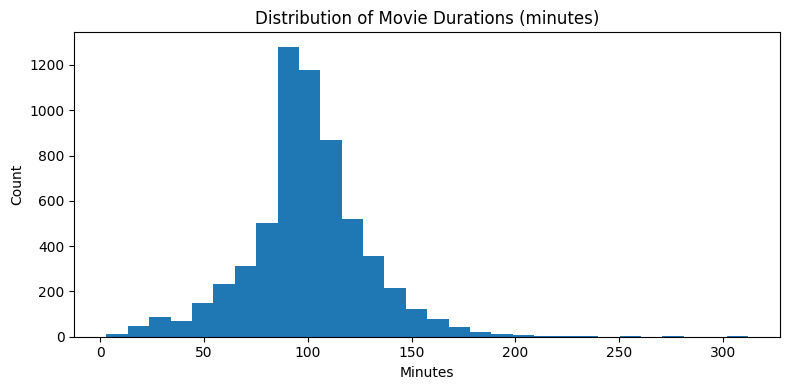

In [ ]:

movies['duration_num_clean'] = movies['duration_num'].dropna().astype(float)
print("Movie duration stats (minutes):")
display(movies['duration_num_clean'].describe())
plt.figure(figsize=(8,4))
plt.hist(movies['duration_num_clean'].dropna(), bins=30)
plt.title("Distribution of Movie Durations (minutes)")
plt.xlabel("Minutes")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("movie_duration_hist.png")
plt.show()

# TV seasons stats

TV seasons stats:


/tmp/ipython-input-2515191976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['seasons'] = tv_shows['duration_num'].dropna().astype(float)


,seasons
count,2676.000000
mean,1.764948
std,1.582752
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,17.000000


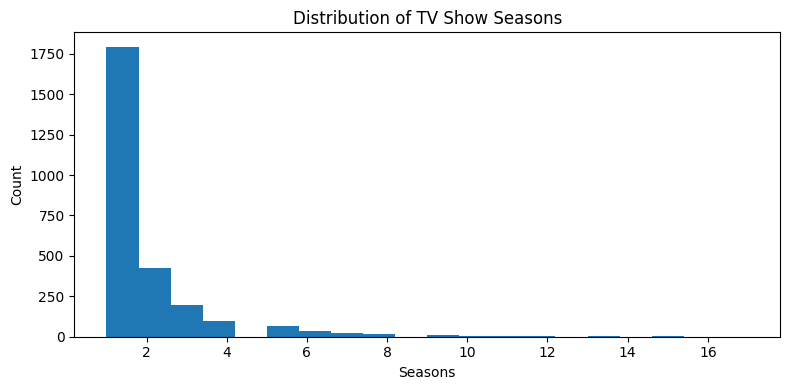

In [ ]:

tv_shows['seasons'] = tv_shows['duration_num'].dropna().astype(float)
print("TV seasons stats:")
display(tv_shows['seasons'].describe())
plt.figure(figsize=(8,4))
plt.hist(tv_shows['seasons'].dropna(), bins=20)
plt.title("Distribution of TV Show Seasons")
plt.xlabel("Seasons")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("tv_seasons_hist.png")
plt.show()

# Top directors & top actors (by how many titles they appear in)

In [ ]:
def top_people(list_col, topn=30):
    cnt = Counter()
    for lst in list_col:
        cnt.update(lst)
    # remove empty keys
    if '' in cnt: del cnt['']
    return pd.DataFrame(cnt.most_common(topn), columns=['person','count'])

In [ ]:
top_directors = top_people(df_clean['director_list'], 30)
top_directors.to_csv("top_directors.csv", index=False)
print("Top directors:")
display(top_directors.head(15))

Top directors:


,person,count
0,Rajiv Chilaka,22
1,Jan Suter,21
2,Raúl Campos,19
3,Suhas Kadav,16
4,Marcus Raboy,16
5,Jay Karas,15
6,Cathy Garcia-Molina,13
7,Youssef Chahine,12
8,Martin Scorsese,12
9,Jay Chapman,12


In [ ]:
top_actors = top_people(df_clean['cast_list'], 40)
top_actors.to_csv("top_actors.csv", index=False)
print("Top actors / cast members:")
display(top_actors.head(20))


Top actors / cast members:


,person,count
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Naseeruddin Shah,32
4,Takahiro Sakurai,32
5,Rupa Bhimani,31
6,Akshay Kumar,30
7,Om Puri,30
8,Yuki Kaji,29
9,Amitabh Bachchan,28


# Plot top actors

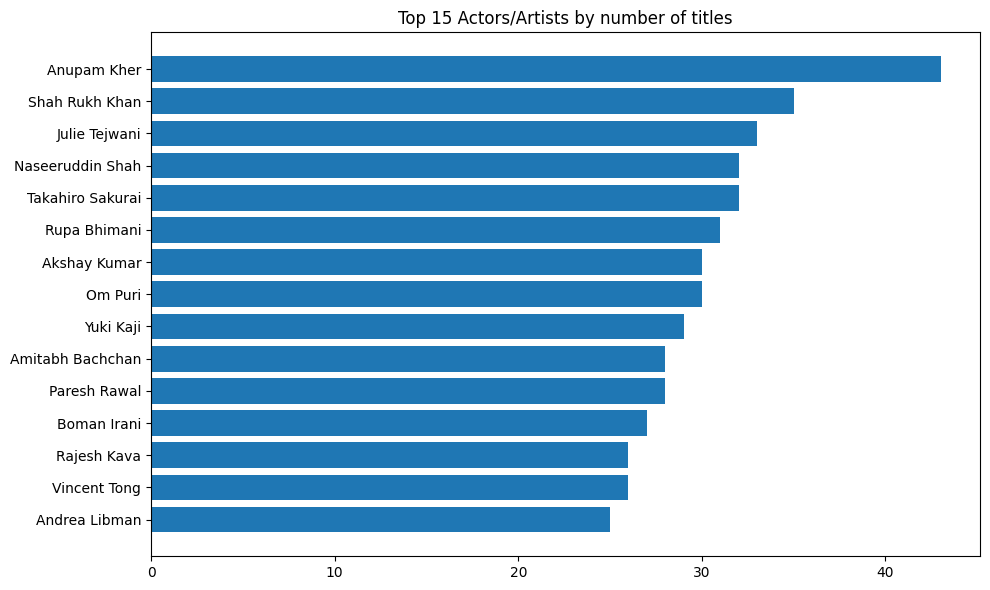

In [ ]:

plt.figure(figsize=(10,6))
plt.barh(top_actors['person'].iloc[:15][::-1], top_actors['count'].iloc[:15][::-1])
plt.title("Top 15 Actors/Artists by number of titles")
plt.tight_layout()
plt.savefig("top_actors.png")
plt.show()

#Long-running / popular-looking TV shows (by number of seasons)

In [ ]:
tv_with_seasons = tv_shows[~tv_shows['seasons'].isna()].sort_values('seasons', ascending=False)
tv_with_seasons[['title','seasons','release_year','country']].head(30).to_csv("top_tv_by_seasons.csv", index=False)
print("Top TV shows by seasons (likely long-running/popular):")
display(tv_with_seasons[['title','seasons','release_year','country']].head(20))


Top TV shows by seasons (likely long-running/popular):


,title,seasons,release_year,country
548,Grey's Anatomy,17.0,2020,United States
2423,Supernatural,15.0,2019,"United States, Canada"
4798,NCIS,15.0,2017,United States
7847,Red vs. Blue,13.0,2015,United States
4220,COMEDIANS of the world,13.0,2019,United States
1354,Heartland,13.0,2019,Canada
5412,Criminal Minds,12.0,2017,"United States, Canada"
4964,Trailer Park Boys,12.0,2018,Canada
6456,Cheers,11.0,1992,United States
6795,Frasier,11.0,2003,United States


#Keyword analysis from descriptions (wordcloud + top words)

In [ ]:
text = " ".join(df_clean['description'].dropna().astype(str).tolist())

In [ ]:
# basic cleaning
text_clean = re.sub(r'[^A-Za-z\s]', ' ', text).lower()
stop_words = set(stopwords.words('english'))
extra_stop = {'season','seasons','episode','episodes','series'}  # domain-specific stopwords
stop_words = stop_words.union(extra_stop)

In [ ]:
words = [w for w in text_clean.split() if w not in stop_words and len(w) > 2]
word_counts = Counter(words)
top_words = pd.DataFrame(word_counts.most_common(50), columns=['word','count'])
top_words.to_csv("top_description_words.csv", index=False)
print("Top words in descriptions:")
display(top_words.head(20))


Top words in descriptions:


,word,count
0,life,845
1,young,729
2,new,709
3,family,635
4,world,570
5,man,538
6,two,505
7,love,504
8,woman,486
9,friends,445


# Wordcloud

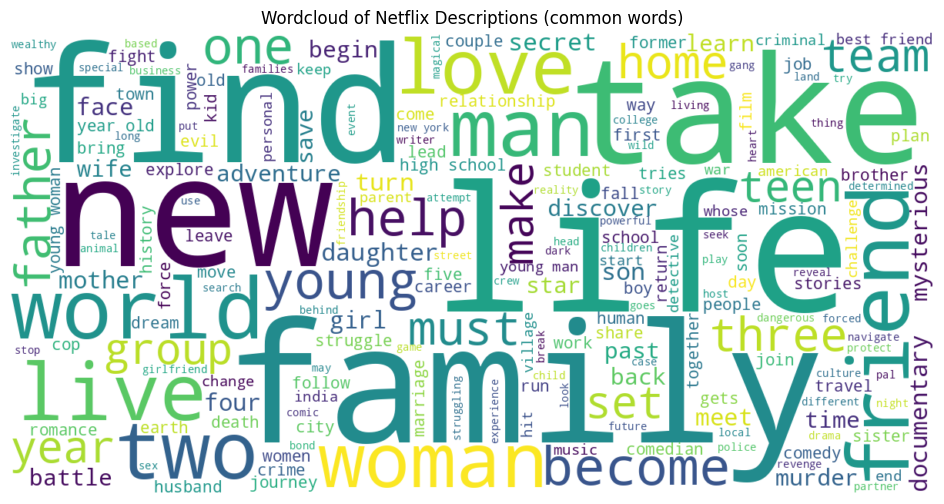

In [ ]:
wc = WordCloud(width=1200, height=600, background_color='white').generate(" ".join(words))
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Netflix Descriptions (common words)")
plt.savefig("wordcloud_descriptions.png")
plt.show()


# Example: Top 20 TV shows in each top genre (sample of 'Popular by Genre')

In [ ]:
# We will find, for a few top genres, the TV shows that belong to them

# top 8 genres
popular_genres = top_genres_overall['genre'].tolist()[:8]
popular_by_genre = {}
for g in popular_genres:
    mask = df_clean['genres_list'].apply(lambda gl: g in gl)
    # prefer TV shows
    subset = df_clean[mask & (df_clean['type'].str.lower() == 'tv show')]
    popular_by_genre[g] = subset[['title','release_year','country','duration','rating']].head(20)
    if len(popular_by_genre[g]) > 0:
        popular_by_genre[g].to_csv(f"top_tv_in_genre_{g.replace(' ','_')}.csv", index=False)

print("Saved top-tv-by-genre CSVs for top genres.")


Saved top-tv-by-genre CSVs for top genres.


# Save overall summary CSVs for your project report

In [ ]:
releases_by_year_df = releases_by_year.reset_index()
releases_by_year_df.columns = ['release_year','count']
releases_by_year_df.to_csv("releases_by_release_year.csv", index=False)
top_genres_overall.to_csv("top_genres_overall.csv", index=False)
top_countries_df.to_csv("top_countries.csv", index=False)
top_directors.to_csv("top_directors.csv", index=False)
top_actors.to_csv("top_actors.csv", index=False)

# Final print summary & file list

In [ ]:
print("\n--- Completed EDA. Files saved in current working directory: ---")
for f in sorted(os.listdir('.')):
    if f.endswith('.png') or f.endswith('.csv'):
        print(f)
print("\nYou can download these files from the Colab Files sidebar or use:")
print("from google.colab import files; files.download('filename')")



--- Completed EDA. Files saved in current working directory: ---
added_by_year.csv
added_by_year.png
movie_duration_hist.png
netflix_titles.csv
rating_distribution.png
ratings_distribution.csv
releases_by_release_year.csv
releases_by_release_year.png
top_actors.csv
top_actors.png
top_countries.csv
top_countries.png
top_description_words.csv
top_directors.csv
top_genres_overall.csv
top_genres_overall.png
top_tv_by_seasons.csv
top_tv_in_genre_International_TV_Shows.csv
top_tv_in_genre_TV_Dramas.csv
tv_seasons_hist.png
wordcloud_descriptions.png

You can download these files from the Colab Files sidebar or use:
from google.colab import files; files.download('filename')


# Show a small sample table of the dataset for reference

In [ ]:
display(df_clean[['title','type','release_year','listed_in','country','rating']].head(10))

,title,type,release_year,listed_in,country,rating
0,Dick Johnson Is Dead,Movie,2020,Documentaries,United States,PG-13
1,Blood & Water,TV Show,2021,"International TV Shows, TV Dramas, TV Mysteries",South Africa,TV-MA
2,Ganglands,TV Show,2021,"Crime TV Shows, International TV Shows, TV Act...",NaN,TV-MA
3,Jailbirds New Orleans,TV Show,2021,"Docuseries, Reality TV",NaN,TV-MA
4,Kota Factory,TV Show,2021,"International TV Shows, Romantic TV Shows, TV ...",India,TV-MA
5,Midnight Mass,TV Show,2021,"TV Dramas, TV Horror, TV Mysteries",NaN,TV-MA
6,My Little Pony: A New Generation,Movie,2021,Children & Family Movies,NaN,PG
7,Sankofa,Movie,1993,"Dramas, Independent Movies, International Movies","United States, Ghana, Burkina Faso, United Kin...",TV-MA
8,The Great British Baking Show,TV Show,2021,"British TV Shows, Reality TV",United Kingdom,TV-14
9,The Starling,Movie,2021,"Comedies, Dramas",United States,PG-13
